In [1]:
import sys; sys.path.append('..') # add project root to the python path

In [2]:
import gym
import numpy as np
import torch
import torch.nn as nn
from IPython.display import YouTubeVideo

from src.part3.MLP import MultiLayerPerceptron as MLP

## 새로운 환경 `CartPole-v1`

이번 실습에서는 새로운 환경을 가지고 여러분들의 강화학습 지식을 "강화" 해볼까요?

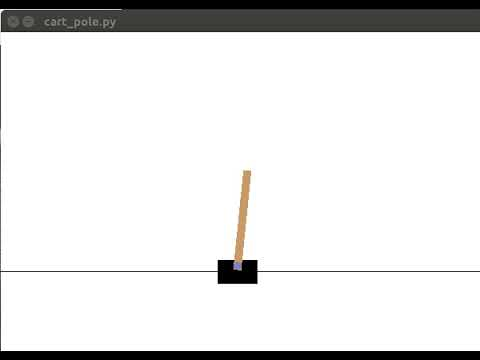

In [3]:
cartpole_link = '37uDD7HFf6U'
YouTubeVideo(cartpole_link, width=800, height=500)

## `CartPole-v1` MDP 알아보기

* openai gym `cartpole.py`의 내용을 참조하여 작성되었습니다. 원문은 [여기](https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py)에서 찾아보실 수 있습니다.
<br>

### `CartPole-v1`  MDP에 적용되는 물리법칙
1. 카트는 마찰이 없는 평면의 트랙위에서 움직인다.
2. 전체 시스템에는 중력이 작용한다. 따라서, 가만히 카트를 두면 막대 (pole)가 떨어진다.

### 인간의 직관을 이용한 솔루션
> ???: 적당히 왼쪽 오른쪽으로 움직여 주면 되겠군...


### MDP의 목적
`CartPole-v1` MDP의 Goal은 카트에 달린 막대를 최대한 오랫동안 __세워두는__ 것입니다. __'세워둔다'__ 의 정의는 막대가 수직으로 부터 15&deg; 이내에 있게 유지하는 것입니다. 추가적으로 평면의 중심에서 2.4 unit 이상 멀어지면 떨어진것으로 간주됩니다.

### 상태 $s$, 행동 $a$, 보상 $r$, 감소율 $\gamma$

>`CartPole-v1` MDP 는 다음과 같은 4-dimensional 상태 $s$ 를 가집니다.
1. x : 카트의 위치
2. θ : 막대의 수직 각도
3. dx/dt : 카트의 속도
4. dθ/dt : 막대의 각속도

>`CartPole-v1` MDP 는 다음과 같은 1-dimensional 상태 $a$ 를 가집니다. <br>
+1, -1 으로 카트에 힘을 가하기. (좌/우로 1의 힘을 가함)

>`CartPole-v1` MDP 는 매 1tick `step()` 마다 1.0 의 보상 $r$ 을 받습니다.

>`CartPole-v1` MDP 감소율 $\gamma$ 이 1.0 입니다.

### `CartPole-v1` MDP 를 "풀었다" ?
`CartPole-v1` MDP에서 100회 연속적으로 195.0의 cumulative reward 를 얻으면, `CartPole-v1` MDP를 "풀었다"라고 정의합니다.

## 랜덤 액션으로 'CartPole-v1' 확인하기

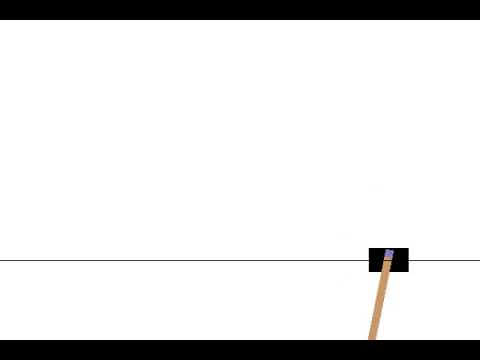

In [4]:
cartpole_link = '4fR836k_T40'
YouTubeVideo(cartpole_link, width=800, height=500)

In [5]:
env = gym.make('CartPole-v1')
env.reset()
for _ in range(1000):
    #env.render() # rendering the outcomes
    env.step(env.action_space.sample()) # take a random action
env.close()

/Users/junyoungpark/.pyenv/versions/3.7.5/envs/torch/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/Users/junyoungpark/.pyenv/versions/3.7.5/envs/torch/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


## 상태공간 $\mathcal{S}$ 및 행동공간 $\mathcal{A}$ 확인하기

OpenAI gym의 환경이니 모름지기 표준화된 interface를 제공하겠죠? 한번 상태공간과 행동공간에 대해서 확인해볼까요?

In [6]:
s_dim = env.observation_space.shape[0]
a_dim = env.action_space.n

print("state space dimension: {}".format(s_dim))
print("action space dimension: {}".format(a_dim))

state space dimension: 4
action space dimension: 2


## Deep Q-Network (DQN): 퍼스트 컨택트

드디어 <파트 3. 함수 근사기법>에서 배운것들이 강화학습과에 처음으로 사용되는 순간입니다! 딥러닝을 이용해서 Q-Learning을 진행해볼까요?

일단 Function approximation을 활용한 Q-Learning의 의사 코드를 살펴봅시다.

<img src="./images/ql_fa.png" width="70%" height="40%" title="q_learning_with_fa" alt="ql_fa"></img>

비교를 위해서 Funciton approximation을 활용하지 않는 경우도 확인 해볼까요?

<img src="../part2/images/q_learning.png" width="70%" height="40%" title="q_learning_with_fa" alt="ql"></img>

## NaiveDQN 을 구현해봅시다!

파이토치 문법에 익숙해질겸 한번 간단한 DQN을 만들어볼까요?

In [7]:
class NaiveDQN(nn.Module):
    
    def __init__(self,
                 state_dim: int,
                 action_dim: int,
                 qnet: nn.Module,
                 lr: float,
                 gamma: float,
                 epsilon: float):
        super(NaiveDQN, self).__init__()
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.qnet = qnet
        self.lr = lr
        self.gamma = gamma
        self.opt = torch.optim.Adam(params=self.qnet.parameters(), lr=lr)
        self.register_buffer('epsilon', torch.ones(1) * epsilon)

        self.criteria = nn.MSELoss()

    def get_action(self, state):
        qs = self.qnet(state)  # Notice that qs is 2d tensor [batch x action]

        if self.train:  # epsilon-greedy policy
            prob = np.random.uniform(0.0, 1.0, 1)
            if torch.from_numpy(prob).float() <= self.epsilon:  # random
                action = np.random.choice(range(self.action_dim))
            else:  # greedy
                action = qs.argmax(dim=-1)
                
        else:  # greedy policy
            action = qs.argmax(dim=-1)
        return int(action)

    def update_sample(self, state, action, reward, next_state, done):
        s, a, r, ns = state, action, reward, next_state
        # Q-Learning target
        q_max, _ = self.qnet(next_state).max(dim=-1)
        q_target = r + self.gamma * q_max * (1 - done)

        # Don't forget to detach `td_target` from the computational graph
        q_target = q_target.detach()

        # Or you can follow a better practice as follows:
        """
        with torch.no_grad():
            q_max, _ = self.qnet(next_state).max(dim=-1)
            q_target = r + self.gamma * q_max * (1 - done)
        """

        loss = self.criteria(self.qnet(s)[0, a], q_target)
        self.opt.zero_grad()
        loss.backward()
        self.opt.step()

In [8]:
qnet = MLP(input_dim=s_dim,
           output_dim=a_dim,
           num_neurons=[128],
           hidden_act='ReLU',
           out_act='Identity')

agent = NaiveDQN(state_dim=s_dim,
                 action_dim=a_dim,
                 qnet=qnet,
                 lr=1e-4,
                 gamma=1.0,
                 epsilon=1.0)

### Training 동안에 모델의 성능을 평가하는 metric을 하나 만들어봅시다.

Q-Learning (따라서, DQN도 포함) 은 행동 정책과 평가의 대상인 타겟 정책이 다릅니다. 따라서, 학습 중간에 모델을 평가하기 위해서는 Agent의 Test behaviour를 사용하는 것이 맞겠죠?

예를 들어,
``` python
for i in range(n_eps): # total training loop
    while True: # episode loop
        ...
        action, get sample, update
        ...
    
    if i % test_every == 0:
        agent.eval() # set agent to the test mode.
        ...
        evaluate the agent on the MDP maybe multiple times!
        ...
        agent.train() # set agent back to the train mode.      
```

하지만, 이렇게 구현을 하면 모델의 evaluation 에 대한 시간적 비용이 상당히 큰 경우들이 많습니다. 그래서 많은 경우에, 모델의 성능을 평가하기 위해서 여태까지 얻었던 에피소드 리턴 --하나의 에피소드에서 얻은 리워드들의 (감가) 합-- 을 사용합니다. 

이번 예제에서는 지수 이동평균법으로 모델의 성능변화를 추적해보도록하죠.

In [9]:
class EMAMeter:
    
    def __init__(self, 
                 alpha:float = 0.5):
        self.s = None
        self.alpha = alpha
    
    def update(self, y):        
        if self.s is None:
            self.s = y
        else:
            self.s = self.alpha * y + (1-self.alpha) * self.s

In [10]:
n_eps = 10000
print_every = 500
ema_factor = 0.5
ema = EMAMeter(ema_factor)

for ep in range(n_eps):
    env.reset()  # restart environment
    cum_r = 0
    while True:
        s = env.state
        s = torch.tensor(s).float().view(1, 4)  # convert to torch.tensor
        a = agent.get_action(s)
        ns, r, done, info = env.step(a)

        ns = torch.tensor(ns).float()  # convert to torch.tensor
        agent.update_sample(s, a, r, ns, done)
        cum_r += r
        if done:
            ema.update(cum_r)

            if ep % print_every == 0:
                print("Episode {} || EMA: {} || EPS : {}".format(ep, ema.s, agent.epsilon))

            if ep >= 150:
                agent.epsilon *= 0.999
            break
env.close()

Episode 0 || EMA: 47.0 || EPS : tensor([1.])
Episode 500 || EMA: 14.76917895158208 || EPS : tensor([0.7046])
Episode 1000 || EMA: 11.964059885294855 || EPS : tensor([0.4272])
Episode 1500 || EMA: 14.384016599387063 || EPS : tensor([0.2591])
Episode 2000 || EMA: 11.708910182458421 || EPS : tensor([0.1571])
Episode 2500 || EMA: 21.414071513075253 || EPS : tensor([0.0953])
Episode 3000 || EMA: 19.83594722137275 || EPS : tensor([0.0578])
Episode 3500 || EMA: 16.06575680638438 || EPS : tensor([0.0350])
Episode 4000 || EMA: 29.446456529947696 || EPS : tensor([0.0212])
Episode 4500 || EMA: 30.11883754420156 || EPS : tensor([0.0129])
Episode 5000 || EMA: 17.15251767455988 || EPS : tensor([0.0078])
Episode 5500 || EMA: 17.95705523749909 || EPS : tensor([0.0047])
Episode 6000 || EMA: 26.480155795527978 || EPS : tensor([0.0029])
Episode 6500 || EMA: 35.194290735829924 || EPS : tensor([0.0017])
Episode 7000 || EMA: 50.60013498566879 || EPS : tensor([0.0011])
Episode 7500 || EMA: 58.26727588766791 

시간이 오래걸릴거에요! 포기하지 마세요 :)

## 다른 사람들의 기록은 어떨까?

[openai gym 사이트](https://gym.openai.com/envs/CartPole-v0/)에 방문하면 다른 사람들의 기록도 확인해볼 수 있습니다.

## 오랜날 오랜밤 그댈 훈련했어요.

많은 머신러닝 모델 그리고 강화학습 모델은 더욱 그러하듯, 모델의 훈련에 생각보다 많은 시간 및 연산자원이 필요합니다. 그래서 훈련된 모델을 잘 저장하는 것이 필요합니다. 파이토치 모델을 저장하는 법을 알아볼까요?

> 모델을 `nn.Module` 을 상속받아서 만들었다고 가정합니다.

### 모델 저장하기

In [11]:
SAVE_PATH = './navie_dqn.pt'
torch.save(agent.state_dict(), SAVE_PATH)

In [12]:
agent.state_dict()

OrderedDict([('epsilon', tensor([5.2495e-05])),
             ('qnet.layers.0.weight',
              tensor([[-2.5274e-01, -1.0068e-01, -6.6648e-01, -1.4273e-01],
                      [ 6.3685e-03,  1.1984e+00,  1.4588e+00,  1.2057e+00],
                      [-7.9896e-01,  1.5624e-01,  5.4470e-01, -1.6938e-01],
                      [-4.4573e-02, -3.0556e-01, -1.8010e+00, -5.5101e-01],
                      [-6.3286e-01, -2.2097e-01,  1.1782e-01, -3.8638e-01],
                      [-7.1657e-01, -3.3559e-01,  6.3424e-01,  5.2899e-01],
                      [-2.9158e-01,  1.0486e-01,  4.6626e-01,  4.8948e-03],
                      [-7.7268e-01,  1.2427e-01,  3.9761e-01, -4.3084e-01],
                      [ 4.8953e-01, -3.7138e-01,  4.8951e-01, -1.5558e-01],
                      [-3.5489e-01,  1.9541e-01,  5.6598e-01, -3.2747e-01],
                      [-2.5850e-01,  2.2271e-02, -1.2181e-01, -1.8363e-01],
                      [-6.6856e-01,  4.2945e-01, -4.1947e-01,  1.1752e-02],
  

### 모델 불러오기

`nn.Module`의 `state_dict()`은 모델의 파라미터 값 및 버퍼의 값들만을 저장합니다. `state_dict()` 자체에는 모델의 구조 및 연산 과정등을 저장하지 않습니다. 따라서 모델을 불러올 때는 저장한 모델과 같은 구조를 가진 모델을 만들고, 그 모델에 디스크에서 불러온 `state_dict()` 를 덮어씌우는 형태로 구현됩니다.

In [13]:
qnet2 = MLP(input_dim=s_dim,
            output_dim=a_dim,
            num_neurons=[128],
            hidden_act='ReLU',
            out_act='Identity')

agent2 = NaiveDQN(state_dim=s_dim,
                  action_dim=a_dim,
                  qnet=qnet,
                  lr=1e-4,
                  gamma=1.0,
                  epsilon=1.0)

In [14]:
agent2.load_state_dict(torch.load(SAVE_PATH))

<All keys matched successfully>

In [15]:
agent2.state_dict()

OrderedDict([('epsilon', tensor([5.2495e-05])),
             ('qnet.layers.0.weight',
              tensor([[-2.5274e-01, -1.0068e-01, -6.6648e-01, -1.4273e-01],
                      [ 6.3685e-03,  1.1984e+00,  1.4588e+00,  1.2057e+00],
                      [-7.9896e-01,  1.5624e-01,  5.4470e-01, -1.6938e-01],
                      [-4.4573e-02, -3.0556e-01, -1.8010e+00, -5.5101e-01],
                      [-6.3286e-01, -2.2097e-01,  1.1782e-01, -3.8638e-01],
                      [-7.1657e-01, -3.3559e-01,  6.3424e-01,  5.2899e-01],
                      [-2.9158e-01,  1.0486e-01,  4.6626e-01,  4.8948e-03],
                      [-7.7268e-01,  1.2427e-01,  3.9761e-01, -4.3084e-01],
                      [ 4.8953e-01, -3.7138e-01,  4.8951e-01, -1.5558e-01],
                      [-3.5489e-01,  1.9541e-01,  5.6598e-01, -3.2747e-01],
                      [-2.5850e-01,  2.2271e-02, -1.2181e-01, -1.8363e-01],
                      [-6.6856e-01,  4.2945e-01, -4.1947e-01,  1.1752e-02],
  